<a href="https://colab.research.google.com/github/JuniorHZ19/ArquitecturasCNN/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install torch torchvision

In [11]:
#AlexNet:
import torch
import torch.nn as nn

class Alexnet(nn.Module):
    def __init__(self,input_channel, num_classes=10):
        super(Alexnet, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(input_channel, 96, kernel_size=11, stride=4,padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Capa fully connected
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.flatten=nn.Flatten(start_dim=1)
        # Activación ReLU
        self.relu = nn.ReLU()
        self.dropout=nn.Dropout(0.5)

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)  # (6, 28, 28)
        x = self.relu(x)
        x = self.pool1(x)  # (6, 14, 14)

        # Segunda capa convolucional
        x = self.conv2(x)  # (16, 10, 10)
        x = self.relu(x)
        x = self.pool2(x)  # (16, 5, 5)

        x=self.conv3(x)
        x=self.relu(x)

        x=self.conv4(x)
        x=self.relu(x)

        x=self.conv5(x)
        x=self.relu(x)
        x=self.pool3(x)

        x=self.flatten(x)

        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc2(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc3(x)


        return x

In [3]:
import torch

# Definir la función de precisión (accuracy)
def accuracy(predicciones, etiquetas_reales, multiclase=False):
    if not multiclase:
        # Para problemas binarios o de clasificación de 2 clases
        predicciones_clase = predicciones.round()
    else:
        # Para clasificación multiclase, usar argmax
        predicciones_clase = torch.argmax(predicciones, dim=1)

    # Contar los aciertos
    aciertos = (predicciones_clase.squeeze() == etiquetas_reales).sum().item()

    # Calcular la precisión
    accuracy = aciertos / len(etiquetas_reales)

    return accuracy

In [4]:
from tqdm import tqdm

def trainModel(model, epochs, dataLoader, dataLoader_test, optimiser, funcion_loss, multiclase=True):
    pbar_epochs=tqdm(total=epochs,desc='Epocas :', position=1,leave=False)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()  # Establecer el modelo en modo de entrenamiento

        pbar_epochs.update(1)
        pbar_dataloader=tqdm(total=len(dataLoader),desc='Dataloader :', position=1,leave=False)

        for batch_data, batch_labels in dataLoader:

            pbar_dataloader.update(1)
            # Hacer la predicción
            output = model(batch_data)

            # Calcular la pérdida
            loss = funcion_loss(output, batch_labels)

            # Reiniciar los gradientes
            optimiser.zero_grad()

            # Retropropagación
            loss.backward()

            # Optimización
            optimiser.step()

            epoch_loss += loss.item()

        # Establecer el modelo en modo evaluación
        model.eval()
        accuracy_total = 0
        with torch.no_grad():
            for batch_data, batch_labels in dataLoader_test:
                output = model(batch_data)

                # Calcular la precisión
                accuracy_total += accuracy(output, batch_labels, multiclase)

        # Calcular el promedio de la precisión
        accuracy_promedio = accuracy_total / len(dataLoader_test)

        # Calcular el promedio de la pérdida
        epoch_loss /= len(dataLoader)

        # Imprimir el progreso
        print(f"Época {epoch+1}, Pérdida: {epoch_loss:.4f}, Precisión: {accuracy_promedio:.4f}")

    return model, optimiser


Files already downloaded and verified
Files already downloaded and verified


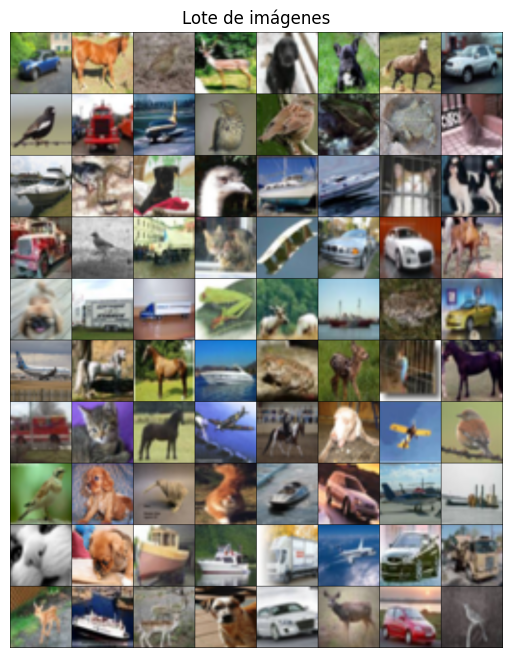

In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),  # Convertir las imágenes a tensores

])

# Cargar el dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False, num_workers=2)


data_lote,labels_lote=next(iter(train_loader))

grid = make_grid(data_lote, nrow=8, padding=2)

# Convertir la cuadrícula a formato visualizable
grid_np = grid.permute(1, 2, 0).numpy()

# Mostrar la cuadrícula
plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Lote de imágenes')
plt.show()

In [19]:
# Inicializar modelo, pérdida y optimizador
import torch.optim as optim
import torch
modelo = Alexnet(input_channel=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelo.parameters(), lr=0.001, momentum=0.9)
epochs=10

modelo_entrenado,optimisador_entrenado=trainModel(modelo,epochs,train_loader,test_loader,optimizer,criterion)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

Predicción: 5
Probabilidad: 0.7876


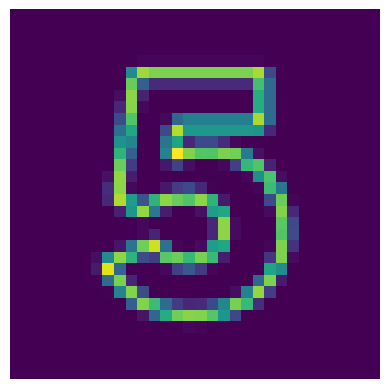

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

# Ruta de la imagen
file_path = "/content/numero-5-7.jpg"  # @param {type:"string"}

# Cargar la imagen
img = Image.open(file_path)

# Transformaciones para la imagen: igual que durante el entrenamiento
transform = transforms.Compose([
   # Convertir a escala de grises
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),  # Redimensionar a 32x32
    transforms.ToTensor(),  # Convertir la imagen a tensor
    transforms.Lambda(lambda x: 1 - x), #invierto colores de negro a blanco
])

# Aplicar las transformaciones
#tensor_img = data_test[5].unsqueeze(0)  # Añadir una dimensión de batch
tensor_img= transform(img).unsqueeze(0)
# Asegurarse de que el modelo esté en modo de evaluación
modelo_entrenado.eval()



# Hacer la predicción
with torch.no_grad():
    output = modelo_entrenado(tensor_img)

# Calcular las probabilidades con softmax
probabilities = F.softmax(output, dim=1)

# Obtener el índice de la clase con la mayor probabilidad
max_value, max_index = torch.max(probabilities, dim=1)

# Definir las clases (dígitos de 0 a 9)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Imprimir la predicción y la probabilidad
print(f'Predicción: {classes[max_index.item()]}')
print(f'Probabilidad: {max_value.item():.4f}')

tensor_img = tensor_img.squeeze(0)  # Eliminar la dimensión de batch, si es necesario

# Deshacer la normalización (si fue realizada previamente)



# Convertir de tensor a imagen PIL
to_pil = transforms.ToPILImage()
image = to_pil(tensor_img)
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para solo mostrar la imagen
plt.show()


In [ ]:
#Guardar modelo y optimzador:

torch.save({
    'model_state_dict': modelo_entrenado.state_dict(),  # Guardar solo los pesos del modelo
    'optimizer_state_dict': optimisador_entrenado.state_dict()  # Guardar el estado del optimizador
}, 'checkpoint.pth')





In [ ]:
#Cargar Modelo Entrenado

modelo_entrenado = LeNet5()  # Asegúrate de definir la clase antes
optimizer_entrenado = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.9)  # Define el optimizador

# Cargar el checkpoint
checkpoint = torch.load('checkpoint.pth')

# Restaurar el estado del modelo y el optimizador
modelo_entrenado.load_state_dict(checkpoint['model_state_dict'])
optimizer_entrenado.load_state_dict(checkpoint['optimizer_state_dict'])

# Si estás en modo de predicción, coloca el modelo en modo evaluación
modelo_entrenado.eval()



<ipython-input-61-1a038789cfa2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (tanth): Tanh()
)